<a href="https://colab.research.google.com/github/KonstantinElfimow/E-commerce-A-B-testing-1/blob/main/E_commerce_A_B_testing_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://drive.google.com/file/d/1yqPQKFKRRXKN8CtGktYLA1qWZG8Njq3V/view?usp=sharing

In [1]:
! gdown --id 1yqPQKFKRRXKN8CtGktYLA1qWZG8Njq3V

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1yqPQKFKRRXKN8CtGktYLA1qWZG8Njq3V
To: /content/archive.zip
100% 3.45M/3.45M [00:00<00:00, 214MB/s]


In [2]:
! unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: ab_test.csv             
  inflating: countries_ab.csv        


# 1. Проведение обзора данных

## 1.1 Подготовка данных

### 1.1.1 Импорт необходимых библиотек

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm

### 1.1.2 Чтение файлов и сохранение полученных данных в переменные

In [4]:
df_ab_test = pd.read_csv('/content/ab_test.csv', sep=',', skipinitialspace=True)
df_countries_ab = pd.read_csv('/content/countries_ab.csv', sep=',', skipinitialspace=True)

### 1.1.3 Получение общей информации о таблицах

In [ ]:
# напишем функцию первичяной проверки данных
def check_data(data_df):
  print('\033[1m' + 'Изучим исходные данные' + '\033[0m')
  print(data_df.info())
  # проверим nan
  print('\033[1m' + '\nПроверка пропусков' + '\033[0m')
  print('Количество пропусков:\n{:.0f}'.format(data_df.isnull().sum().sum()))
  print('Доля пропусков:\n{}'.format(data_df.isna().mean()))
  # проверим дубликаты
  print('\033[1m' + '\nПроверка на дубликаты' + '\033[0m')
  print('Количество полных дубликатов:\n', data_df.duplicated().sum())
  # посмотрим на сами данные
  print('\033[1m' + '\nПервые 10 строк датасета' + '\033[0m')
  display(data_df.head(10))

  print('\033[1m' + '\nОписание количественных данных:' + '\033[0m')
  display(data_df.describe(exclude=['object']).T)

  print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
  display(data_df.describe(include=['object']).T)

  print('\033[1m' + '\nВывод уникальных значений'\
  ' по каждому признаку:' + '\033[0m')

  for i in data_df.columns:
    print('\033[1m' + str(i) + '\033[0m')
    display(data_df[i].value_counts())

In [ ]:
check_data(df_ab_test)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   con_treat  294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None

Проверка пропусков
Количество пропусков:
0
Доля пропусков:
id           0.0
time         0.0
con_treat    0.0
page         0.0
converted    0.0
dtype: float64

Проверка на дубликаты
Количество полных дубликатов:
 0

Первые 10 строк датасета


,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
5,936923,20:49.1,control,old_page,0
6,679687,26:46.9,treatment,new_page,1
7,719014,48:29.5,control,old_page,0
8,817355,58:09.0,treatment,new_page,1
9,839785,11:06.6,treatment,new_page,1



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
id,294478.0,787974.124733,91210.823776,630000.0,709032.25,787933.5,866911.75,945999.0
converted,294478.0,0.119659,0.324563,0.0,0.00,0.0,0.00,1.0



Описание категориальных данных:


,count,unique,top,freq
time,294478,35993,36:26.7,22
con_treat,294478,2,treatment,147276
page,294478,2,old_page,147239



Вывод уникальных значений по каждому признаку:
id


805339    2
754884    2
722274    2
783176    2
898232    2
         ..
642985    1
771499    1
923606    1
712675    1
715931    1
Name: id, Length: 290584, dtype: int64

time


36:26.7    22
33:53.2    22
02:54.5    21
27:20.8    21
18:31.9    21
           ..
09:36.9     1
21:52.8     1
47:07.1     1
41:10.7     1
52:49.2     1
Name: time, Length: 35993, dtype: int64

con_treat


treatment    147276
control      147202
Name: con_treat, dtype: int64

page


old_page    147239
new_page    147239
Name: page, dtype: int64

converted


0    259241
1     35237
Name: converted, dtype: int64

In [ ]:
check_data(df_countries_ab)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB
None

Проверка пропусков
Количество пропусков:
0
Доля пропусков:
id         0.0
country    0.0
dtype: float64

Проверка на дубликаты
Количество полных дубликатов:
 0

Первые 10 строк датасета


,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK
5,909908,UK
6,811617,US
7,938122,US
8,887018,US
9,820683,US



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
id,290584.0,788004.876222,91224.735468,630000.0,709034.75,787995.5,866956.25,945999.0



Описание категориальных данных:


,count,unique,top,freq
country,290584,3,US,203619



Вывод уникальных значений по каждому признаку:
id


834778    1
800343    1
907039    1
750441    1
808681    1
         ..
848198    1
730439    1
864977    1
862567    1
934996    1
Name: id, Length: 290584, dtype: int64

country


US    203619
UK     72466
CA     14499
Name: country, dtype: int64

### 1.1.4 Выводы

Согласно приведённому выше первичному анализу df_ab_test, можно сделать следующие выводы:
1. Наименования столбцов соответствуют формату PEP8.
2. id - id клиента на сайте; time - время сессии клиента на сайте; con_treat - контрольная или экспериментальная группа, на которой тестятся лэндинги; page - тип страницы (old_page - старый лэндинг сайта, new_page - новый лэндинг сайта); converted - маржа (0, 1), по типу (купил/не купил), больше информации нет.
3. Пропусков и дубликатов у нас не наблюдается. Данные достаточно чистые, чтобы с ними работать.

Согласно приведённому выше первичному анализу df_countries_ab, можно сделать следующие выводы:
1. Наименования столбцов соответствуют формату PEP8.
2. id - id клиента на сайте; country - страна, где живёт клиент.
3. Пропусков и дубликатов у нас не наблюдается. Данные достаточно чистые, чтобы с ними работать.

## 1.2 Анализ данных

### 1.2.1 Графическое представление данных из таблиц

**Доп пункт**

Т.к. у нас есть временные ряды, но они представлены в виде object, то, очевидно, нужно перевести time к виду datetime и образовать n-количество интервалов, сколько времени проводит клиент на сайте, - это понадобится нам в будущем. Сделаю это сейчас:

In [ ]:
# перевожу время к формату datetime
df_ab_test['time'] = pd.to_datetime(df_ab_test['time'].astype(str).str.strip(),
                                    format='%M:%S.%f')
# образую временные интервалы
df_ab_test['time_intervals'] = pd.cut(df_ab_test['time'], bins=10)

**Продолжаем**

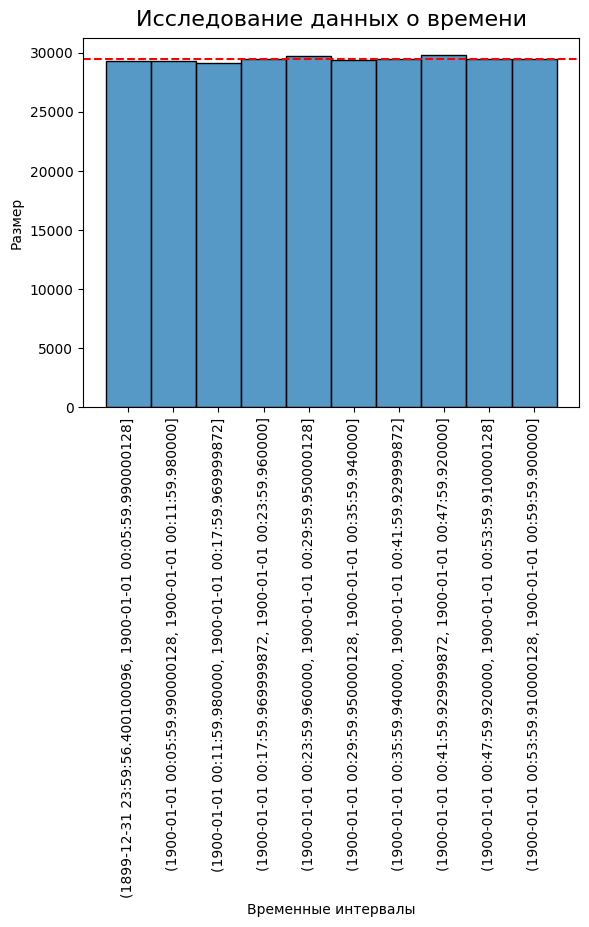

In [25]:
sns.histplot(df_ab_test['time_intervals'].astype(str).sort_values(),
             edgecolor='black')
plt.ylabel('Размер')
plt.xlabel('Временные интервалы')
plt.xticks(rotation=90)  # Поворот подписей на оси x на 90 градусов

# Добавление пунктирной красной линии на ось y,
# обозначающей среднее ожидаемое значение
mean_value = len(df_ab_test) / len(df_ab_test['time_intervals'].unique())
plt.axhline(y=mean_value, color='r', linestyle='--')

plt.title('Исследование данных о времени', fontsize=16, y=1.01)
plt.show();

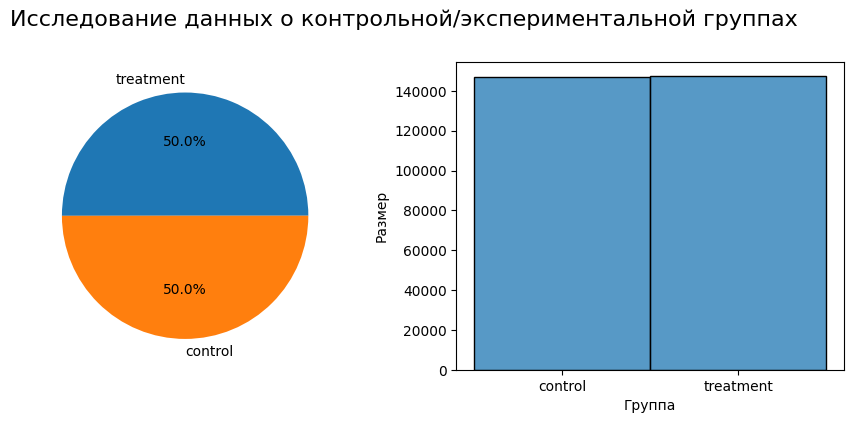

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

df_ab_test['con_treat'].value_counts().plot(kind='pie',
                                            ax=axes[0],
                                            autopct='%1.1f%%')
axes[0].set_ylabel('')
axes[0].set_title('')

sns.histplot(df_ab_test['con_treat'].astype(str), ax=axes[1])
axes[1].set_xlabel('Группа')
axes[1].set_ylabel('Размер')
axes[1].set_title('')

plt.suptitle('Исследование данных о контрольной/экспериментальной группах',
             fontsize=16, y=1.01)

plt.show();

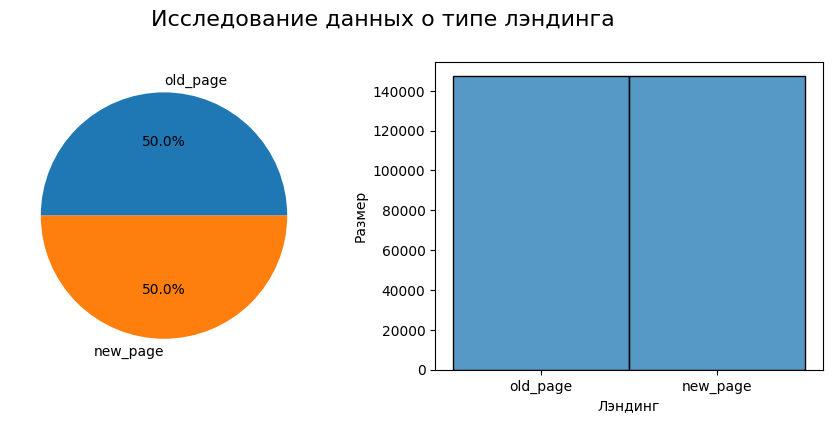

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

df_ab_test['page'].value_counts().plot(kind='pie',
                                       ax=axes[0],
                                       autopct='%1.1f%%')
axes[0].set_ylabel('')
axes[0].set_title('')

sns.histplot(df_ab_test['page'].astype(str), ax=axes[1])
axes[1].set_xlabel('Лэндинг')
axes[1].set_ylabel('Размер')
axes[1].set_title('')

plt.suptitle('Исследование данных о типе лэндинга', fontsize=16, y=1.01)

plt.show();

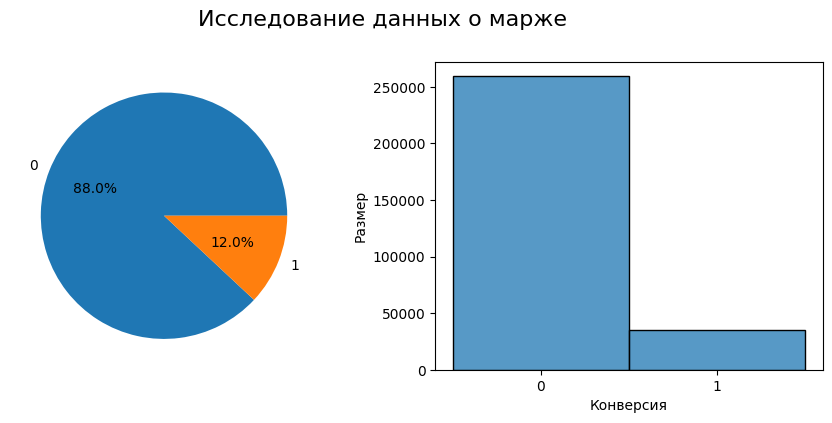

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

df_ab_test['converted'].value_counts().plot(kind='pie',
                                            ax=axes[0],
                                            autopct='%1.1f%%')
axes[0].set_ylabel('')
axes[0].set_title('')

sns.histplot(df_ab_test['converted'].astype(str), ax=axes[1])
axes[1].set_xlabel('Конверсия')
axes[1].set_ylabel('Размер')
axes[1].set_title('')

plt.suptitle('Исследование данных о марже', fontsize=16, y=1.01)

plt.show();

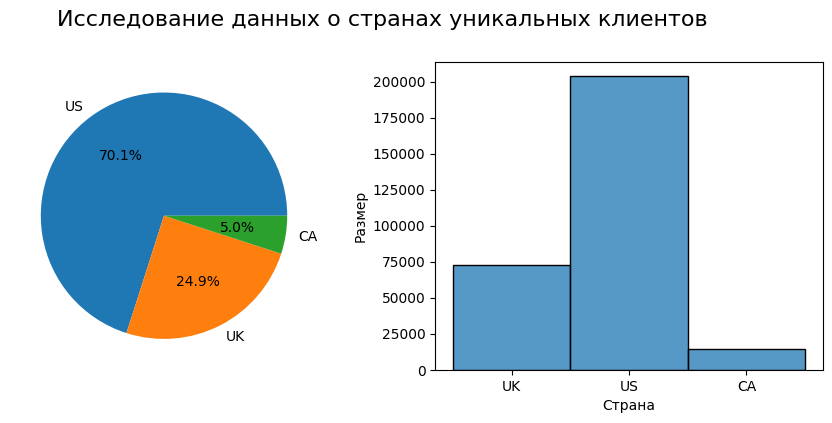

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

df_countries_ab['country'].value_counts().plot(kind='pie',
                                            ax=axes[0],
                                            autopct='%1.1f%%')
axes[0].set_ylabel('')
axes[0].set_title('')

sns.histplot(df_countries_ab['country'], ax=axes[1])
axes[1].set_xlabel('Страна')
axes[1].set_ylabel('Размер')
axes[1].set_title('')

plt.suptitle('Исследование данных о странах уникальных клиентов',
             fontsize=16, y=1.01)

plt.show();

### 1.2.2 Выводы

1. Мы взглянули более детально на соотношение и размеры каждой группы категориальных данных.
2. Аномалий во временных рядах выявлено не было.

# 1.3 Предобработка данных

### 1.3.1 Корректировка типов данных

Можно перевести con_treat, page и time_intervals к dtype category в df_ab_test. А converted к dtype bool, т.к. значений тут всего 2 уникальных, это слишком большой расход памяти, если оставить всё как есть.

In [35]:
cols = df_ab_test.select_dtypes(include='object').columns
df_ab_test[cols] = df_ab_test[cols].astype('category')
df_ab_test['converted'] = df_ab_test['converted'].astype(bool)

In [36]:
df_ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              294478 non-null  int64         
 1   time            294478 non-null  datetime64[ns]
 2   con_treat       294478 non-null  category      
 3   page            294478 non-null  category      
 4   converted       294478 non-null  bool          
 5   time_intervals  294478 non-null  category      
dtypes: bool(1), category(3), datetime64[ns](1), int64(1)
memory usage: 5.6 MB


До этого был memory usage 11.2+ MB

Аналогично, в df_countries_ab можно перевести country к dtype category, т.к. тут всего 3 уникальных значения.

In [37]:
cols = df_countries_ab.select_dtypes(include='object').columns
df_countries_ab[cols] = df_countries_ab[cols].astype('category')

In [38]:
df_countries_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   id       290584 non-null  int64   
 1   country  290584 non-null  category
dtypes: category(1), int64(1)
memory usage: 2.5 MB


До этого был memory usage 4.4+ MB

### 1.3.2 Выделение признаков и таргета

Могу с уверенностью сказать, что time_intervals, con_treat, page, country - это признаки, которые необходимо учитывать для дальнейшей работы, а converted - единственный таргет.

### 1.3.3 Соединение таблиц

In [41]:
# Объединим датафрейм
df = pd.merge(df_ab_test, df_countries_ab, how='inner', on='id')
# Назначим id клиента в качестве индекса в нашем датафрейме
df = df.set_index('id')
display(df)

,time,con_treat,page,converted,time_intervals,country
id,,,,,,
851104,1900-01-01 00:11:48.600,control,old_page,False,"(1900-01-01 00:05:59.990000128, 1900-01-01 00:...",US
804228,1900-01-01 00:01:45.200,control,old_page,False,"(1899-12-31 23:59:56.400100096, 1900-01-01 00:...",US
661590,1900-01-01 00:55:06.200,treatment,new_page,False,"(1900-01-01 00:53:59.910000128, 1900-01-01 00:...",US
853541,1900-01-01 00:28:03.100,treatment,new_page,False,"(1900-01-01 00:23:59.960000, 1900-01-01 00:29:...",US
864975,1900-01-01 00:52:26.200,control,old_page,True,"(1900-01-01 00:47:59.920000, 1900-01-01 00:53:...",US
...,...,...,...,...,...,...
751197,1900-01-01 00:28:38.600,control,old_page,False,"(1900-01-01 00:23:59.960000, 1900-01-01 00:29:...",US
945152,1900-01-01 00:51:57.100,control,old_page,False,"(1900-01-01 00:47:59.920000, 1900-01-01 00:53:...",US
734608,1900-01-01 00:45:03.400,control,old_page,False,"(1900-01-01 00:41:59.929999872, 1900-01-01 00:...",US


### 1.3.4 Выводы

1. Скорректировали типы данных.
2. Пропусков и дубликатов не было, поэтому ничего не требовалось удалять или заполнять.
3. Выделели признаки и таргет.
4. Соединили таблицу в одну общую.

## 1.4 Исследование итоговой таблицы с данными

### 1.4.1 Аналитический анализ

**Анализируем соотношение групп old_page/new_page и control/treatment**

http://quantile.ru/06/06-Literacy1.pdf

In [110]:
# Соотношение количества treatment/control, old/new_page
table = pd.pivot_table(df, index='con_treat', columns='page', aggfunc='size')
display(table)

page,new_page,old_page
con_treat,,
control,1928,145274
treatment,145311,1965


**Анализируем независимость групп**

In [118]:
index1 = df[(df['page'] == 'old_page') & (df['con_treat'] == 'control')].index.tolist()
index2 = df[(df['page'] == 'new_page') & (df['con_treat'] == 'treatment')].index.tolist()
intersection = list(set(index1) & set(index2))
psb = df.loc[intersection, :]
print('Пересечения в (old_page + control) и (new_page + treatment):', len(psb))

index1 = df[(df['page'] == 'old_page') & (df['con_treat'] == 'treatment')].index.tolist()
index2 = df[(df['page'] == 'new_page') & (df['con_treat'] == 'control')].index.tolist()
intersection = list(set(index1) & set(index2))
psb = df.loc[intersection, :]
print('Пересечения в (old_page + treatment) и (new_page + control):', len(psb))

index1 = df[(df['page'] == 'new_page') & (df['con_treat'] == 'control')].index.tolist()
index2 = df[(df['page'] == 'old_page') & (df['con_treat'] == 'control')].index.tolist()
intersection = list(set(index1) & set(index2))
psb = df.loc[intersection, :]
print('Пересечения в (new_page + control) и (old_page + control):', len(psb))

index1 = df[(df['page'] == 'new_page') & (df['con_treat'] == 'treatment')].index.tolist()
index2 = df[(df['page'] == 'old_page') & (df['con_treat'] == 'treatment')].index.tolist()
intersection = list(set(index1) & set(index2))
psb = df.loc[intersection, :]
print('Пересечения в (new_page + treatment) и (old_page + treatment):', len(psb))

Пересечения в (old_page + control) и (new_page + treatment): 0
Пересечения в (old_page + treatment) и (new_page + control): 0
Пересечения в (new_page + control) и (old_page + control): 2014
Пересечения в (new_page + treatment) и (old_page + treatment): 1982


1. (old_page + control) и (new_page + treatment) - независимые группы (подходят для A/B теста).
2. (old_page + treatment) и (new_page + control) - независимые группы (подходят для A/B теста).
3. Все остальные имеют зависимости.

### 1.4.2 Корреляционный анализ

In [69]:
def crammer_and_pvalue(df, col1: str, col2: str):
  data = pd.pivot_table(df, index=col1, columns=col2, aggfunc='size')
  data = data.fillna(0).astype(int)
  data = data.to_numpy()
  chi2, pvalue = chi2_contingency(data, correction=True)[:2]
  n = np.sum(data)
  min_dim = min(data.shape) - 1
  corr = np.sqrt((chi2 / n) / min_dim)
  return corr, pvalue

**Анализ 1**

Заданимся вопросом, увеличилась ли конверсия в зависимости от страны проживания пользователей, если они уже увидели оба варианта лэндинга (зависимые группы)?

In [138]:
index1 = df[(df['page'] == 'old_page') &
            (df['con_treat'] == 'control')].index.tolist()
index2 = df[(df['page'] == 'new_page') &
            (df['con_treat'] == 'control')].index.tolist()
intersection = list(set(index1) & set(index2))
psb = df.loc[intersection, :]

result = []
for country in df['country'].unique():
  corr, pvalue = crammer_and_pvalue(
      psb[(psb['country'] == country)],
      'page',
      'converted'
      )
  result.append([country, round(corr, 4), round(pvalue)])
corr, pvalue = crammer_and_pvalue(psb, 'page', 'converted')
result.append(['no_matter', round(corr, 4), round(pvalue, 4)])
result.sort(key=lambda x: x[2])

zipped = list(zip(*result))

result = pd.DataFrame({'cтрана_проживания': zipped[0],
                       'корреляция': zipped[1],
                       'р_значение': zipped[2]})
display(result)

,cтрана_проживания,корреляция,р_значение
0,US,0.0256,0.0000
1,no_matter,0.0176,0.4304
2,CA,0.0498,1.0000
3,UK,0.0115,1.0000


**Вывод:** будем полагать, что есть зависимость от страны проживания пользователя, если они видели как старый, так и новый лэндинг. Можно с уверенностью сказать, что клиенты из US практически не изменили своё поведение в связи с изменением в сайте.

**Анализ 2**

Заданимся вопросом, отличается ли время пребывания пользователя из US (они наши основные пользователи - 70% от всех юзеров), если он уже увидел оба варианта лэндинга (зависимые группы) и какая конверсия у этого поведения?

In [139]:
index1 = df[(df['page'] == 'old_page') &
            (df['con_treat'] == 'control') &
            (df['country'] == 'US')].index.tolist()
index2 = df[(df['page'] == 'new_page') &
            (df['con_treat'] == 'control') &
            (df['country'] == 'US')].index.tolist()
intersection = list(set(index1) & set(index2))
psb = df.loc[intersection, :]
psb = psb.reset_index()

result = []
for time_interval in df['time_intervals'].unique():
  corr, pvalue = crammer_and_pvalue(
      psb[(psb['time_intervals'] == time_interval)],
      'page',
      'converted'
      )
  result.append([str(time_interval), round(corr, 4), round(pvalue, 4)])
corr, pvalue = crammer_and_pvalue(psb, 'page', 'converted')
result.append(['no_matter', round(corr, 4), round(pvalue, 4)])
result.sort(key=lambda x: x[2])

zipped = list(zip(*result))

result = pd.DataFrame(
    {'временной_интервал': zipped[0],
     'корреляция': zipped[1],
     'р_значение': zipped[2]}
    )
display(result)

,временной_интервал,корреляция,р_значение
0,"(1900-01-01 00:05:59.990000128, 1900-01-01 00:...",0.1217,0.1401
1,"(1900-01-01 00:23:59.960000, 1900-01-01 00:29:...",0.1162,0.1800
2,"(1900-01-01 00:29:59.950000128, 1900-01-01 00:...",0.1060,0.2361
3,no_matter,0.0256,0.3389
4,"(1900-01-01 00:11:59.980000, 1900-01-01 00:17:...",0.0732,0.3901
5,"(1900-01-01 00:35:59.940000, 1900-01-01 00:41:...",0.0687,0.4268
6,"(1900-01-01 00:17:59.969999872, 1900-01-01 00:...",0.0677,0.4419
7,"(1900-01-01 00:53:59.910000128, 1900-01-01 00:...",0.0293,0.7242
8,"(1900-01-01 00:47:59.920000, 1900-01-01 00:53:...",0.0217,0.7970
9,"(1899-12-31 23:59:56.400100096, 1900-01-01 00:...",0.0000,1.0000


**Вывод:** существует очень слабая связь с тем, что пользователь сидит на сайте больше 6 (в целом у нас минимальное значение и есть 6 минут), но меньше 12 минут и конверсией (но не понятно в лучшую или худшую сторону). Ещё более слабые и более недостоверные связи наблюдаются, если пользователь сидит больше 24, но меньше 36 минут.

### 1.4.3 Графический анализ

**Анализ 1**

Всё тот же анализ, что и выше, но уже со взглядом на график.

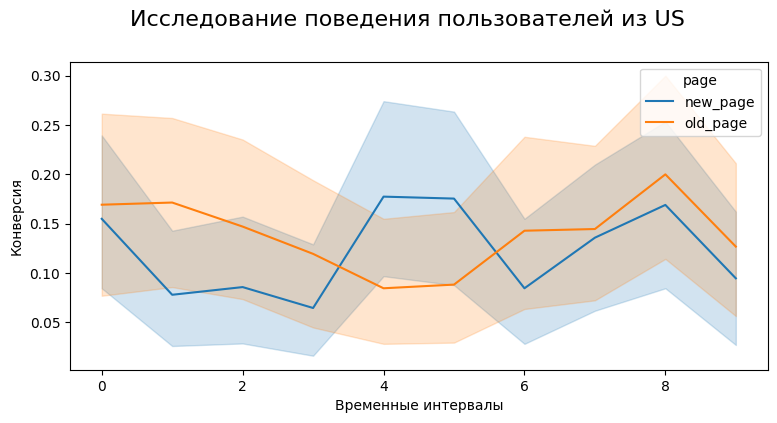

In [140]:
index1 = df[(df['page'] == 'old_page') &
            (df['con_treat'] == 'control') &
            (df['country'] == 'US')].index.tolist()
index2 = df[(df['page'] == 'new_page') &
            (df['con_treat'] == 'control') &
            (df['country'] == 'US')].index.tolist()
intersection = list(set(index1) & set(index2))
psb = df.loc[intersection, :]
psb = psb.reset_index()

fig, axes = plt.subplots(1, 1, figsize=(9, 4))

sns.lineplot(y='converted', x=psb['time_intervals'].cat.codes, hue='page', data=psb, ax=axes)
axes.set_xlabel('Временные интервалы')
axes.set_ylabel('Конверсия')
axes.set_title('')

plt.suptitle('Исследование поведения пользователей из US', fontsize=16, y=1.01)

plt.show()

Вывод: видно, что в 1-й промежуток есть та самая слабая связь, но она направлена сторону ухудшения в связи с изменениями на сайте. Зато в теории 4 и 5 промежутки стали приносить чуть больше конверсии, чем было до этого.

In [136]:
t = pd.DataFrame(psb.groupby(['time_intervals', 'page']).size())
t.columns = ['size']
t['p'] = t['size'] / t.groupby(['page'])['size'].transform('sum')
t['converted'] = psb.groupby(['time_intervals', 'page'])['converted'].mean()

m1 = (t.loc[(slice(None), 'old_page'), 'converted'] *
      t.loc[(slice(None), 'old_page'), 'p']).sum()
print('Мат ожидание конверсии со старой страницей: ', round(m1, 4))

m2 = (t.loc[(slice(None), 'new_page'), 'converted'] *
      t.loc[(slice(None), 'new_page'), 'p']).sum()
print('Мат ожидание конверсии с новой страницей: ', round(m2, 4))

Мат ожидание конверсии со старой страницей:  0.1394
Мат ожидание конверсии с новой страницей:  0.1207


Мат ожидание от конверсии ожидается ниже на ~2% процента для клиентов из US, кто уже видел сайт раньше.

In [134]:
t

size         p  \
time_intervals                                     page                       
(1899-12-31 23:59:56.400100096, 1900-01-01 00:0... new_page   190  0.095477   
                                                   old_page    65  0.093391   
(1900-01-01 00:05:59.990000128, 1900-01-01 00:1... new_page   217  0.109045   
                                                   old_page    70  0.100575   
(1900-01-01 00:11:59.980000, 1900-01-01 00:17:5... new_page   201  0.101005   
                                                   old_page    68  0.097701   
(1900-01-01 00:17:59.969999872, 1900-01-01 00:2... new_page   183  0.091960   
                                                   old_page    67  0.096264   
(1900-01-01 00:23:59.960000, 1900-01-01 00:29:5... new_page   192  0.096482   
                                                   old_page    71  0.102011   
(1900-01-01 00:29:59.950000128, 1900-01-01 00:3... new_page   177  0.088945   
                                                   old_page    68  0.097701   
(1900-01-01 00:35:59.940000, 1900-01-01 00:41:5... new_page   193  0.096985   
                                                   old_page    63  0.090517   
(1900-01-01 00:41:59.929999872, 1900-01-01 00:4... new_page   210  0.105528   
                                                   old_page    83  0.119253   
(1900-01-01 00:47:59.920000, 1900-01-01 00:53:5... new_page   211  0.106030   
                                                   old_page    70  0.100575   
(1900-01-01 00:53:59.910000128, 1900-01-01 00:5... new_page   216  0.108543   
                                                   old_page    71  0.102011   

                                                             converted  
time_intervals                                     page                 
(1899-12-31 23:59:56.400100096, 1900-01-01 00:0... new_page   0.136842  
                                                   old_page   0.169231  
(1900-01-01 00:05:59.990000128, 1900-01-01 00:1... new_page   0.096774  
                                                   old_page   0.171429  
(1900-01-01 00:11:59.980000, 1900-01-01 00:17:5... new_page   0.139303  
                                                   old_page   0.147059  
(1900-01-01 00:17:59.969999872, 1900-01-01 00:2... new_page   0.065574  
                                                   old_page   0.119403  
(1900-01-01 00:23:59.960000, 1900-01-01 00:29:5... new_page   0.145833  
                                                   old_page   0.084507  
(1900-01-01 00:29:59.950000128, 1900-01-01 00:3... new_page   0.129944  
                                                   old_page   0.088235  
(1900-01-01 00:35:59.940000, 1900-01-01 00:41:5... new_page   0.108808  
                                                   old_page   0.142857  
(1900-01-01 00:41:59.929999872, 1900-01-01 00:4... new_page   0.138095  
                                                   old_page   0.144578  
(1900-01-01 00:47:59.920000, 1900-01-01 00:53:5... new_page   0.118483  
                                                   old_page   0.200000  
(1900-01-01 00:53:59.910000128, 1900-01-01 00:5... new_page   0.087963  
                                                   old_page   0.126761

In [95]:
# import plotly.graph_objects as go

# # Создание sankey-диаграммы
# fig = go.Figure(data=[go.Sankey(
#     node=dict(
#         pad=15,
#         thickness=20,
#         line=dict(color="black", width=0.5),
#         label=["id", "old", "new", "control", "treatment", "converted"],
#     ),
#     link=dict(
#         source=[0, 0, 1, 1, 2, 2, 3, 3],
#         target=[1, 2, 3, 4, 4, 5, 4, 5],
#         value=[2, 1, 1, 1, 2, 1, 2, 1]
#     )
# )])

# # Отображение диаграммы
# fig.show()

# 2. A/B тестирование

## 2.1 A/B тест (новый лэндинг лучше старого?)

In [128]:
index1 = df[(df['page'] == 'old_page') &
            (df['con_treat'] == 'control') &
            (df['country'] == 'US')].index.tolist()
index2 = df[(df['page'] == 'new_page') &
            (df['con_treat'] == 'treatment') &
            (df['country'] == 'US')].index.tolist()
union = list(set(index1) | set(index2))
group_ab = df.loc[union, :]

table_ab = pd.pivot_table(group_ab, index='con_treat', values='converted', aggfunc='sum')
table_ab['size'] = group_ab.groupby('con_treat').size()
table_ab['cr'] = table_ab['converted'] / table_ab['size']
display(table_ab)

,converted,size,cr
con_treat,,,
control,12424,103059,0.120552
treatment,12257,103305,0.118649


In [148]:
es = sms.proportion_effectsize(table_ab.loc['control', 'cr'],
                               table_ab.loc['treatment', 'cr'])
n = np.ceil(sms.NormalIndPower().solve_power(es,
                                             power=0.8,
                                             alpha=0.05,
                                             ratio=1))

count = 1000
result = []
group_1 = group_ab[group_ab['con_treat'] == 'control']['converted']
group_2 = group_ab[group_ab['con_treat'] == 'treatment']['converted']
for _ in tqdm(range(count)):
  a = group_1.sample(n=int(n), replace=True)
  b = group_2.sample(n=int(n), replace=True)
  pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative='larger')[1]
  result.append(pval)

  0%|          | 0/1000 [00:00<?, ?it/s]

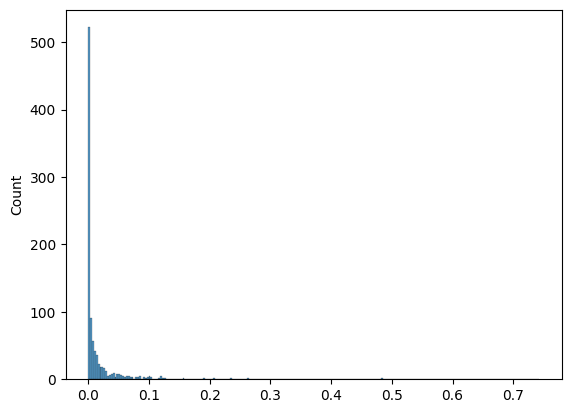

In [149]:
# построение гистограммы для p-value
sns.histplot(result);

**Вывод:**
1. Eсть основания отвергнуть H0, эти группы различны.
2. Более того, введение нового лэндинга будет большой ошибкой для компании, которая ухудшит конверсию на сайте.

## 2.2 B/A тест (раньше было лучше?)

In [142]:
index1 = df[(df['page'] == 'new_page') &
            (df['con_treat'] == 'control') &
            (df['country'] == 'US')].index.tolist()
index2 = df[(df['page'] == 'old_page') &
            (df['con_treat'] == 'treatment') &
            (df['country'] == 'US')].index.tolist()
union = list(set(index1) | set(index2))
group_ba = df.loc[union, :]

table_ba = pd.pivot_table(group_ba, index='con_treat', values='converted', aggfunc='sum')
table_ba['size'] = group_ba.groupby('con_treat').size()
table_ba['cr'] = table_ba['converted'] / table_ba['size']
display(table_ba)

,converted,size,cr
con_treat,,,
control,343,2743,0.125046
treatment,359,2745,0.130783


In [150]:
es = sms.proportion_effectsize(table_ba.loc['control', 'cr'],
                               table_ba.loc['treatment', 'cr'])
n = np.ceil(sms.NormalIndPower().solve_power(es,
                                             power=0.8,
                                             alpha=0.05,
                                             ratio=1))

count = 1000
result = []
group_1 = group_ba[group_ba['con_treat'] == 'control']['converted']
group_2 = group_ba[group_ba['con_treat'] == 'treatment']['converted']
for _ in tqdm(range(count)):
  a = group_1.sample(n=int(n), replace=True)
  b = group_2.sample(n=int(n), replace=True)
  pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative='smaller')[1]
  result.append(pval)

  0%|          | 0/1000 [00:00<?, ?it/s]

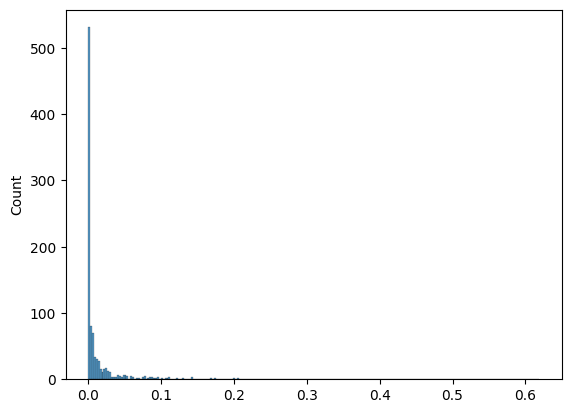

In [151]:
# построение гистограммы для p-value
sns.histplot(result);

**Вывод:**
1. Eсть основания отвергнуть H0, эти группы различны.
2. Руководство компании признало свою ошибку, что они не послушали отдел аналитики, из-за чего маржа стала меньше. И попросили проверить, как отнесутся пользователи к тому, что сайт вернётся к первоначальному виду. К счастью для них, B/A тест прошёл успешно! Это было хорошее решение вернуть сайт к старому виду, конверсия на сайте повысилась.